In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
mortality = pd.read_csv('/Users/wenhuizeng/Library/Mobile Documents/com~apple~CloudDocs/high performance/week4/healthcare2/Mortality.csv')
patient = pd.read_csv('/Users/wenhuizeng/Library/Mobile Documents/com~apple~CloudDocs/high performance/week4/healthcare2/Patient.csv')
patient = patient[patient['Gender']!="MISSING"]

### Q1.1 Are men more likely to die than women in this group of patients? Assume people without a date of death in the mortality table are still alive.

In [7]:
patient.columns.values

array(['PatientID', 'FirstName', 'LastName', 'State', 'ZipCode',
       'DateOfBirth', 'Gender', 'Race', 'Income'], dtype=object)

In [8]:
patient_death = pd.merge(patient,mortality,how="left",on="PatientID")

In [9]:
#patient_death['death']=0
patient_death['death'] = np.where(patient_death['DateOfDeath'].isnull(), 0, 1)

In [10]:
patient_death.head()

,PatientID,FirstName,LastName,State,ZipCode,DateOfBirth,Gender,Race,Income,DateOfDeath,death
0,1,Diana,Huddleston,WI,53186,1962-02-27,female,NaN,1076.167979,NaN,0
1,2,Marion,Poston,IL,60527,1859-09-11,male,white,475.781094,2008-11-02,1
2,3,Sandra,Hamby,IL,60126,1946-02-15,female,white,30.747987,NaN,0
3,4,Mildred,Krehbiel,ID,83702,1979-07-27,female,white,160.596425,2016-01-17,1
4,5,Abigail,Flores,PA,19131,1983-02-19,female,?,NaN,NaN,0


In [11]:
#patient_death.groupby(['Gender'])['death'].sum()

In [12]:
df = patient_death.groupby(['Gender']).agg({'death': ['sum','count']})
#df = patient_death[patient_death['Gender']!='MISSING'].groupby(['Gender'])['death'].count()
df.columns = df.columns.droplevel(level=0)#if not drop it will be like one other level death
df['mortality rate']=df['sum']/df['count']
df

,sum,count,mortality rate
Gender,,,
female,3337,9504,0.351115
male,3209,8927,0.359471


Yes. Male is more likely to die than female

### Q1.2 I am interested to know if there are patterns in the disease groups across gender. For every patient with at least one outpatient visit, identify if they have been diagnosed with any of the 22 conditions listed in the diseaseMap table at any time point. You will need to consider all three ICD columns in the outpatientVisit file (not just one). Create a table with the rate of disease for each condition for men, women, and all. It should look like this, where the XX% is the percent with the condition:

In [13]:
disease = pd.read_csv('/Users/wenhuizeng/Library/Mobile Documents/com~apple~CloudDocs/high performance/week4/healthcare2/DiseaseMap.csv')
icdcodes = pd.read_csv('/Users/wenhuizeng/Library/Mobile Documents/com~apple~CloudDocs/high performance/week4/healthcare2/ICDCodes.csv')
outpatient = pd.read_csv('/Users/wenhuizeng/Library/Mobile Documents/com~apple~CloudDocs/high performance/week4/healthcare2/OutpatientVisit.csv')

In [25]:
outpatient
outpatient['PatientID'].unique() 

array([    1,     2,     3, ..., 19998, 19999, 20000])

Because people who are in the outpatient visit table means they are have at least visiting, so I don't need to filter out the patients.

In [72]:
outpatient_long = outpatient[['PatientID','ICD10_1','ICD10_2','ICD10_3']].melt(id_vars='PatientID',var_name='ICD10_num',value_name='ICD10')
#outpatient_long = outpatient.loc[:,['PatientID','ICD10_1','ICD10_2','ICD10_3']].melt(id_vars='PatientID',var_name='ICD10_num',value_name='ICD10')
#iloc only subset integer


In [73]:
outpatient_long.head()

,PatientID,ICD10_num,ICD10
0,1,ICD10_1,E10621
1,1,ICD10_1,K269
2,1,ICD10_1,E10621
3,1,ICD10_1,K269
4,1,ICD10_1,K269


In [211]:
df1 = pd.merge(outpatient_long[['PatientID','ICD10']],disease[['ICD10','Condition']],how='inner',on='ICD10')
#if only subset one variable, one [] is good, if subest two variables need two [[]]
#left_on or right_on
df2 = pd.merge(df1,patient[['Gender','PatientID']],how='inner',on='PatientID')
df3 = df2.groupby(['Gender','Condition'])['PatientID'].nunique()/df2.groupby(['Gender'])['PatientID'].nunique()
df4 = pd.DataFrame(df3.unstack(level=0)).reset_index(level=0, drop=False,inplace=False)

Gender,Condition,female,male
0,Alcohol,0.103135,0.106196
1,Cancer,0.066471,0.066428
2,Congestive_heart_failure,0.040722,0.074620
3,Dementia,0.042401,0.039619
4,Depression,0.165407,0.111856
5,Diabetes_with_complications,0.055556,0.051236
6,Diabetes_without_complications,0.136300,0.130325
7,Drugs,0.054156,0.051087
8,HIV,0.007557,0.008341
9,Hypertension,0.379513,0.426869


In [235]:
df5 = pd.DataFrame(df2.groupby(['Condition'])['PatientID'].nunique()/df2['PatientID'].nunique())
df5.columns.values[0] = "All"

In [236]:
df5.reset_index(level=0, inplace=True)

In [237]:
pd.merge(df4,df5,how='inner',on='Condition')

,Condition,female,male,All
0,Alcohol,0.103135,0.106196,0.105252
1,Cancer,0.066471,0.066428,0.066106
2,Congestive_heart_failure,0.040722,0.074620,0.057283
3,Dementia,0.042401,0.039619,0.040896
4,Depression,0.165407,0.111856,0.139846
5,Diabetes_with_complications,0.055556,0.051236,0.053782
6,Diabetes_without_complications,0.136300,0.130325,0.132633
7,Drugs,0.054156,0.051087,0.052241
8,HIV,0.007557,0.008341,0.007983
9,Hypertension,0.379513,0.426869,0.401190


### Q3 Calculate the mortality rate for every year between 2005 and 2018. Is it generally increasing, or decreasing? Assume patients are only at risk of death as of their first visit (in the outpatient Visit file). Once they have died, they are no longer at risk in subsequent years...
 This is a harder question to answer than at first glance. What should the denominator of patients be for every year? How will you calculate it?


In [335]:
visit = outpatient.sort_values(by=['VisitDate']).drop_duplicates(subset='PatientID', keep='first')[['PatientID','VisitDate']]
visit = visit[visit['VisitDate'].notnull()]
visit['risk_date'] = pd.to_datetime(visit['VisitDate'])
visit['risk_year'] = visit['risk_date'].dt.year.astype('int')


In [350]:
#mortality['deathyear']=mortality['DateOfDeath'].dt.year
mortality['death_date'] = pd.to_datetime(mortality['DateOfDeath'])
mortality['deathyear']=mortality['death_date'].dt.year #datetime attribute dt

In [357]:
df_death_visit = pd.merge(visit,mortality,how='left',on='PatientID')
df_death_visit['death'] = np.where(df_death_visit['death_date'].isnull(),0,1)
df_death_visit.head()
df_death_visit['deathyear'] = np.where(df_death_visit['deathyear'].isnull(),2019,df_death_visit['deathyear'])
df_death_visit['deathyear'] =df_death_visit['deathyear'].astype('int')

In [358]:
death_summary = df_death_visit.groupby(['deathyear']).agg({'death':'sum'})
death_summary.columns.values[0]="Number of Patient Died Each Year"
death_summary.head()
death_summary.reset_index(level=0, inplace=True)
death_summary

,deathyear,Number of Patient Died Each Year
0,2005,34
1,2006,157
2,2007,247
3,2008,329
4,2009,395
5,2010,483
6,2011,523
7,2012,598
8,2013,611
9,2014,618


The death summary table is different from the summary table I summarized from the mortality table. Because some patient never visit hospital before they died. So they never be risk. We want calculate the number of people who died each year divided the number of people at risk each year. If we include people who died however never been at risk, the mortality rate will greater than 1. It is not possible. The summary table using mortality table is created below.

In [359]:
death_summary_t = mortality.groupby(['deathyear']).agg({'PatientID':'nunique'})
death_summary_t.columns.values[0]="Number of Patient Died Each Year"
death_summary_t.head()
death_summary_t.reset_index(level=0, inplace=True)

In [360]:
death_summary_t

,deathyear,Number of Patient Died Each Year
0,2005,79
1,2006,235
2,2007,356
3,2008,423
4,2009,479
5,2010,567
6,2011,605
7,2012,689
8,2013,715
9,2014,710


In [361]:
df_death_visit.head()

,PatientID,VisitDate,risk_date,risk_year,DateOfDeath,death_date,deathyear,death
0,4649,2005-01-04,2005-01-04,2005,2006-10-02,2006-10-02,2006,1
1,6057,2005-01-06,2005-01-06,2005,NaN,NaT,2019,0
2,16409,2005-01-12,2005-01-12,2005,2007-01-31,2007-01-31,2007,1
3,7778,2005-01-14,2005-01-14,2005,NaN,NaT,2019,0
4,14138,2005-01-18,2005-01-18,2005,NaN,NaT,2019,0


In here I treated patient at risk from the first visit to the year he died.

In [362]:
df_at_risk = df_death_visit[['PatientID','risk_year','deathyear']].melt(id_vars='PatientID',value_name='Year').sort_values(by=['PatientID'])

In [402]:
def riskyear(key):
    df = df_at_risk[df_at_risk['PatientID']==key]
    df_year = pd.DataFrame({'Year' : range(min(df['Year']), max(df['Year'])+1 ,1)})
    df = pd.merge(df_year,df,how='outer',on='Year')
    df = df.fillna(method='ffill')    
    return df

In [403]:
key=df_death_visit['PatientID'].unique()
df_risk = pd.concat(map(riskyear,key ))

In [424]:
risk_summary=pd.DataFrame(df_risk.groupby(['Year'])['PatientID'].count())
risk_summary.reset_index(level=0,inplace=True)

In [431]:
summary= pd.merge(death_summary[death_summary['deathyear']!=2019],risk_summary,how='left',left_on=['deathyear'],right_on=['Year'])

In [433]:
summary['mortality_rate']=summary['Number of Patient Died Each Year']/summary['PatientID']

In [434]:
summary

,deathyear,Number of Patient Died Each Year,Year,PatientID,mortality_rate
0,2005,34,2005,893,0.038074
1,2006,157,2006,2364,0.066413
2,2007,247,2007,3782,0.065309
3,2008,329,2008,5160,0.063760
4,2009,395,2009,6516,0.060620
5,2010,483,2010,7728,0.062500
6,2011,523,2011,8867,0.058983
7,2012,598,2012,9950,0.060101
8,2013,611,2013,10871,0.056205
9,2014,618,2014,11786,0.052435


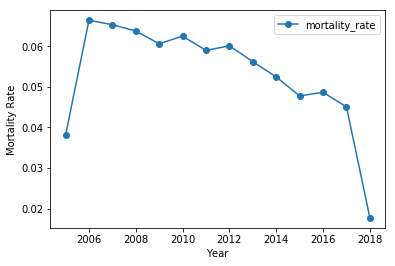

In [443]:

plt.plot(summary['Year'], summary['mortality_rate'],marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Mortality Rate') 
plt.legend()
# Show the plot
plt.show()



The mortality rate is not always increase. It increased from 2005 to 2006 and decreased from 2006 to 2018.